In [1]:
import numpy as np
from math import factorial

# Let's define the Parameters
lambda_1 = 0.5  # Arrival rate for type 1 calls
lambda_2 = 0.3  # Arrival rate for type 2 calls
mu_1 = 1      # Service rate for server 1
mu_2 = 2      # Service rate for server 2
T = 30        # Time horizon
M = 5         # Maximum queue size  
gamma = 0.9   # Discount factor
theta = 0.1   # Convergence threshold 

# Poisson PMF function for arrivals
def poisson_pmf(lambda_rate, k, t=1):
    return (lambda_rate * t) ** k * np.exp(-lambda_rate * t) / factorial(k)

# Reward function
def reward(n1, n2):
    return -(n1 + n2)  # Negative of total waiting in both queues

# Let's initialise the state variables
states = [(n1, n2, S1, S2) for n1 in range(M+1) 
          for n2 in range(M+1) 
          for S1 in [0, 1] 
          for S2 in [0, 1]]
actions = ['a1', 'a2', 'a1_a2']  # Actions: a1 -> handle type 1, a2 -> handle type 2

# Value function and policy initialisation
V = {state: 0 for state in states}  # Let's initialise all states' values to 0
policy = {state: None for state in states}  # Let's initialise policy for each state

# Transition function: define how the state changes given an action
def get_next_state(current_state, action, verbose=False):
    n1, n2, S1, S2 = current_state
    
     # Checking if servers are busy 
    if (n2 > 0 and S2 == 1) or (S1 == 1 and S2 == 1): # Since S2 can only handle type 2 calls
        if verbose:
            print("The server is currently busy")
        return current_state  # Return the current state unchanged

 
    # Defining transitions for actions
    if action == 'a1':    
        if n1 > 0 and S1 == 0: # When S1 available for type 1 calls
            return (n1 - 1, n2, 1, S2)  
        elif n1 > 0 and S2 == 0: # When S2 available for type 1 calls
            return (n1 - 1, n2, S1, 1)  
    
    elif action == 'a2':
        if n2 > 0 and S2 == 0: # Only type 2 calls for S2
            return (n1, n2 - 1, S1, 1)
        
    elif action == 'a1_a2':
        if n1 > 0 and S1 == 0 and n2 > 0 and S2 == 0:  # Both servers handle calls
            return (n1 - 1, n2 - 1, 1, 1)
        elif n1 > 1 and S1 == 0 and S2 == 0:
            return (n1 - 2, n2, 1, 1)

    return current_state  # No valid action, return the current state

# Value iteration using Bellman's equation
for _ in range(T):  # Limiting the number of iterations to the time horizon
    delta = 0
    for state in states:
        v = V[state]  # Current value of the state
        n1, n2, S1, S2 = state  # Unpacking the state

        action_values = []  # To store the value of taking each action

        # Skiping updating policy when all queues and servers are empty
        if (n1 == 0 and n2 == 0 and S1 == 0 and S2 == 0):
            policy[state] = "No Specific Action - Just update the queue"
            continue

        for action in actions:
            # Suppressing the "busy" message during value iteration by setting verbose=False
            next_state = get_next_state(state, action, verbose=False)
            
            # Calculating Poisson probabilities for new arrivals (assuming time step = 1)
            arrivals_1 = np.random.poisson(lambda_1)
            arrivals_2 = np.random.poisson(lambda_2)
            prob_arrival_1 = poisson_pmf(lambda_1, arrivals_1)
            prob_arrival_2 = poisson_pmf(lambda_2, arrivals_2)
            
            # Calculating the reward and transition probability weighted value of the next state
            immediate_reward = reward(*state[:2])
            
            # Bellman's equation
            action_value = prob_arrival_1 * prob_arrival_2 * (immediate_reward + gamma * V[next_state])
            action_values.append(action_value) # appending action_value

        # Updating the value of the state with the maximum action value
        if action_values:
            V[state] = max(action_values)
        delta = max(delta, abs(v - V[state]))

    # Convergence check
    if delta < theta:
        break

# Deriving the optimal policy by choosing the action with the maximum expected reward for each state
for state in states:
    best_action = "No Specific Action - Just update the queue"  # Default policy is "NA" when no action can be taken
    best_value = -float('inf')
    n1, n2, S1, S2 = state  # Unpacking the state

    # Skiping updating policy when all queues and servers are empty
    if (n1 == 0 and n2 == 0 and S1 == 0 and S2 == 0):
        policy[state] = "No Specific Action - Just update the queue"
        continue

    for action in actions:
        # Suppressing the "busy" message during policy calculation by setting verbose=False
        next_state = get_next_state(state, action, verbose=False)
        action_value = (reward(*state[:2]) + gamma * V[next_state])
        
        if action_value > best_value:
            best_value = action_value
            best_action = action
    
    policy[state] = best_action

In [2]:
# Output the optimal policy and the final value function
print("Optimal Policy:")
for state, action in policy.items():
    # Enabling verbose output to see "busy" message when executing the policy 
    next_state = get_next_state(state, action, verbose=True) if action != "No Specific Action - Just update the queue" else state
    print(f"State {state}: Action {action}, \n Next State: {next_state}\n")


Optimal Policy:
State (0, 0, 0, 0): Action No Specific Action - Just update the queue, 
 Next State: (0, 0, 0, 0)

State (0, 0, 0, 1): Action a1, 
 Next State: (0, 0, 0, 1)

State (0, 0, 1, 0): Action a1, 
 Next State: (0, 0, 1, 0)

The server is currently busy
State (0, 0, 1, 1): Action a1, 
 Next State: (0, 0, 1, 1)

State (0, 1, 0, 0): Action a2, 
 Next State: (0, 0, 0, 1)

The server is currently busy
State (0, 1, 0, 1): Action a1, 
 Next State: (0, 1, 0, 1)

State (0, 1, 1, 0): Action a2, 
 Next State: (0, 0, 1, 1)

The server is currently busy
State (0, 1, 1, 1): Action a1, 
 Next State: (0, 1, 1, 1)

State (0, 2, 0, 0): Action a2, 
 Next State: (0, 1, 0, 1)

The server is currently busy
State (0, 2, 0, 1): Action a1, 
 Next State: (0, 2, 0, 1)

State (0, 2, 1, 0): Action a1, 
 Next State: (0, 2, 1, 0)

The server is currently busy
State (0, 2, 1, 1): Action a1, 
 Next State: (0, 2, 1, 1)

State (0, 3, 0, 0): Action a2, 
 Next State: (0, 2, 0, 1)

The server is currently busy
Sta

In [3]:
# Simulation function with exponential service times
def simulate_policy(policy, T=T):
    np.random.seed(42)
    
    # Initial state: no calls in queues, both servers idle
    state = (0, 0, 0, 0)  
    queue_1_len = []
    queue_2_len = []
    waiting_costs = []
    total_waiting_cost = 0
    total_queue_len = []
    immediate_costs = []
    
    # Tracking remaining service time for each server
    server1_time_remaining = 0  # Time left for server 1 to finish the current call
    server2_time_remaining = 0  # Time left for server 2 to finish the current call
    
    # Track the total number of calls in queues
    total_calls_in_queue_1 = 0
    total_calls_in_queue_2 = 0

    print("Starting simulation...\n")

    for t in range(T):
        
        # Checking if servers have completed their current calls
        if server1_time_remaining > 0:
            server1_time_remaining -= 1
        if server2_time_remaining > 0:
            server2_time_remaining -= 1

        # Ensuring non-negative values for time remaining
        server1_time_remaining = max(0, server1_time_remaining)
        server2_time_remaining = max(0, server2_time_remaining)

        # Updating state to reflect server idleness if time remaining is zero
        if server1_time_remaining == 0:
            state = (state[0], state[1], 0, state[3])  # Server 1 is now idle
        if server2_time_remaining == 0:
            state = (state[0], state[1], state[2], 0)  # Server 2 is now idle

        # Determining action based on policy
        action = policy[state] if state in policy else "No Specific Action - Just update the queue"
        
        # Prioritising a1_a2 if both servers are available and there are multiple type 1 calls
        if state[0] > 1 and state[2] == 0 and state[3] == 0:
            action = "a1_a2"
        elif action == "a1" and state[0] == 0:  # No type 1 calls for a1
            action = "No Specific Action - Just update the queue"
        elif action == "a2" and state[1] == 0:  # No type 2 calls for a2
            action = "No Specific Action - Just update the queue"
        
    
        # Calculating immediate cost and update total waiting cost
        immediate_cost = reward(*state[:2])
        immediate_costs.append(immediate_cost) 
        total_waiting_cost += immediate_cost

        # Recording queue lengths and cumulative waiting cost
        queue_1_len.append(state[0])
        queue_2_len.append(state[1])
        waiting_costs.append(total_waiting_cost)
        total_queue_len.append((state[0], state[1]))
        total_calls_in_queue_1 += state[0]
        total_calls_in_queue_2 += state[1]

        # Printing simulation details
        print(f"Time Step {t}:")
        print(f"  Current State = {state}")
        print(f"  Selected Action = {action}")
        print(f"  Immediate Waiting Cost = {immediate_cost}")
        print(f"  Cumulative Waiting Cost = {total_waiting_cost}")
        print(f"  Total Calls in Queue 1 (so far) = {total_calls_in_queue_1}")
        print(f"  Total Calls in Queue 2 (so far) = {total_calls_in_queue_2}")

        
        # Executing actions 
        if action == "a1":
            if state[0] > 0:
                if state[2] == 0:  # Server 1 available
                    state = get_next_state(state, action)
                    server1_time_remaining = np.random.exponential(1 / mu_1)
                    state = (state[0], state[1], 1, state[3])  # Set Server 1 as busy
                elif state[3] == 0:  # Server 2 available
                    state = get_next_state(state, action)
                    server2_time_remaining = np.random.exponential(1 / mu_1)
                    state = (state[0], state[1], state[2], 1)  # Set Server 2 as busy

        elif action == "a2" and state[1] > 0 and state[3] == 0:  # Server 2 handles a type 2 call
            state = get_next_state(state, action)
            server2_time_remaining = np.random.exponential(1 / mu_2)
            state = (state[0], state[1], state[2], 1)  # Set Server 2 as busy

        elif action == "a1_a2":
            # Server 1 takes a type 1 call if available
            if state[0] > 0 and state[2] == 0:
                state = get_next_state(state, action)
                server1_time_remaining = np.random.exponential(1 / mu_1)
                state = (state[0], state[1], 1, state[3])  # Set Server 1 as busy
            
            # Server 2 takes a type 2 call if available, otherwise a type 1 call
            if state[1] > 0 and state[3] == 0:  # Server 2 handles type 2 call if there's one
                state = get_next_state(state, action)
                server2_time_remaining = np.random.exponential(1 / mu_2)
                state = (state[0], state[1], state[2], 1)  # Set Server 2 as busy
            elif state[0] > 1 and state[2] == 1 and state[3] == 0:  # Server 2 handles type 1 call if no type 2 calls
                state = get_next_state(state, action)
                server2_time_remaining = np.random.exponential(1 / mu_1)
                state = (state[0], state[1], state[2], 1)  # Set Server 2 as busy

        else:
            # New arrivals if no specific action is taken
            arrivals_1 = np.random.poisson(lambda_1)
            arrivals_2 = np.random.poisson(lambda_2)
            state = (min(state[0] + arrivals_1, M), min(state[1] + arrivals_2, M), state[2], state[3])
            
            print(f"  New Arrivals - Type 1: {arrivals_1}, Type 2: {arrivals_2}")
            print(f"  Updated State after Arrivals = {state}")

        # Server time remaining
        print(f"  Server 1 Time Remaining: {server1_time_remaining}")
        print(f"  Server 2 Time Remaining: {server2_time_remaining}")
        print(f"  Next State after Action = {state}\n")

    avg_queue_1 = sum(queue_1_len) / T
    avg_queue_2 = sum(queue_2_len) / T

    return total_waiting_cost, avg_queue_1, avg_queue_2, queue_1_len, queue_2_len, waiting_costs, total_queue_len, total_calls_in_queue_1, total_calls_in_queue_2, immediate_costs

# Run Simulation
total_cost, avg_queue_1, avg_queue_2, queue_1_len, queue_2_len, waiting_costs, total_queue_len, total_calls_in_queue_1, total_calls_in_queue_2, immediate_costs = simulate_policy(policy, T=T)

Starting simulation...

Time Step 0:
  Current State = (0, 0, 0, 0)
  Selected Action = No Specific Action - Just update the queue
  Immediate Waiting Cost = 0
  Cumulative Waiting Cost = 0
  Total Calls in Queue 1 (so far) = 0
  Total Calls in Queue 2 (so far) = 0
  New Arrivals - Type 1: 0, Type 2: 1
  Updated State after Arrivals = (0, 1, 0, 0)
  Server 1 Time Remaining: 0
  Server 2 Time Remaining: 0
  Next State after Action = (0, 1, 0, 0)

Time Step 1:
  Current State = (0, 1, 0, 0)
  Selected Action = a2
  Immediate Waiting Cost = -1
  Cumulative Waiting Cost = -1
  Total Calls in Queue 1 (so far) = 0
  Total Calls in Queue 2 (so far) = 1
  Server 1 Time Remaining: 0
  Server 2 Time Remaining: 0.4564712768879766
  Next State after Action = (0, 0, 0, 1)

Time Step 2:
  Current State = (0, 0, 0, 0)
  Selected Action = No Specific Action - Just update the queue
  Immediate Waiting Cost = 0
  Cumulative Waiting Cost = -1
  Total Calls in Queue 1 (so far) = 0
  Total Calls in Queue 2

In [4]:
# Print summary of results
print("Summary of Simulation Results:")
print("Immediate Cost in Each Step:", immediate_costs)
print("Waiting Cost in Each Step:", waiting_costs)

print("Total Waiting Cost:", total_cost)
print("Average Queue Length (Queue 1):", avg_queue_1)
print("Average Queue Length (Queue 2):", avg_queue_2)
print(f"Total Calls in Queue 1 over simulation: {total_calls_in_queue_1}")
print(f"Total Calls in Queue 2 over simulation: {total_calls_in_queue_2}")

Summary of Simulation Results:
Immediate Cost in Each Step: [0, -1, 0, 0, -1, 0, -2, -1, 0, 0, 0, -1, 0, -1, 0, 0, -1, 0, -2, -1, 0, 0, -1, 0, 0, 0, -5, -3, -1, 0]
Waiting Cost in Each Step: [0, -1, -1, -1, -2, -2, -4, -5, -5, -5, -5, -6, -6, -7, -7, -7, -8, -8, -10, -11, -11, -11, -12, -12, -12, -12, -17, -20, -21, -21]
Total Waiting Cost: -21
Average Queue Length (Queue 1): 0.43333333333333335
Average Queue Length (Queue 2): 0.26666666666666666
Total Calls in Queue 1 over simulation: 13
Total Calls in Queue 2 over simulation: 8


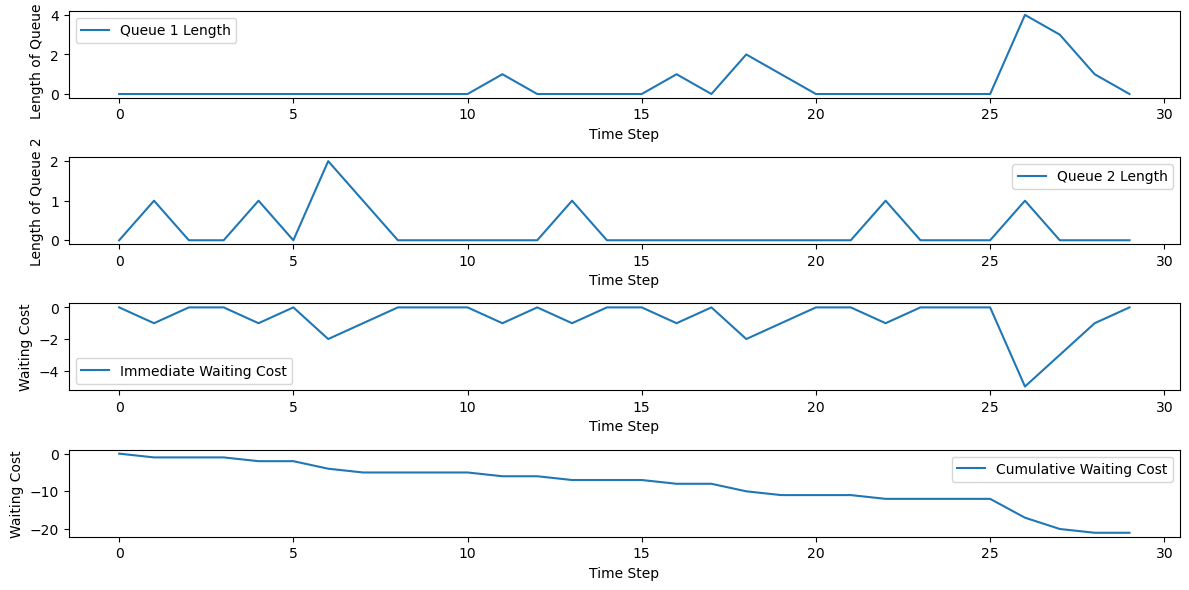

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

#  Queue 1 Length
plt.subplot(4, 1, 1)
plt.plot(queue_1_len, label="Queue 1 Length")
plt.xlabel("Time Step")
plt.ylabel("Length of Queue 1")
plt.legend()

#  Queue 2 Length
plt.subplot(4, 1, 2)
plt.plot(queue_2_len, label="Queue 2 Length")
plt.xlabel("Time Step")
plt.ylabel("Length of Queue 2")
plt.legend()

#  Immediate Costs
plt.subplot(4, 1, 3)
plt.plot(immediate_costs, label="Immediate Waiting Cost")
plt.xlabel("Time Step")
plt.ylabel("Waiting Cost")
plt.legend()

#  Waiting Costs
plt.subplot(4, 1, 4)
plt.plot(waiting_costs, label="Cumulative Waiting Cost")
plt.xlabel("Time Step")
plt.ylabel("Waiting Cost")
plt.legend()


plt.tight_layout()
plt.show()

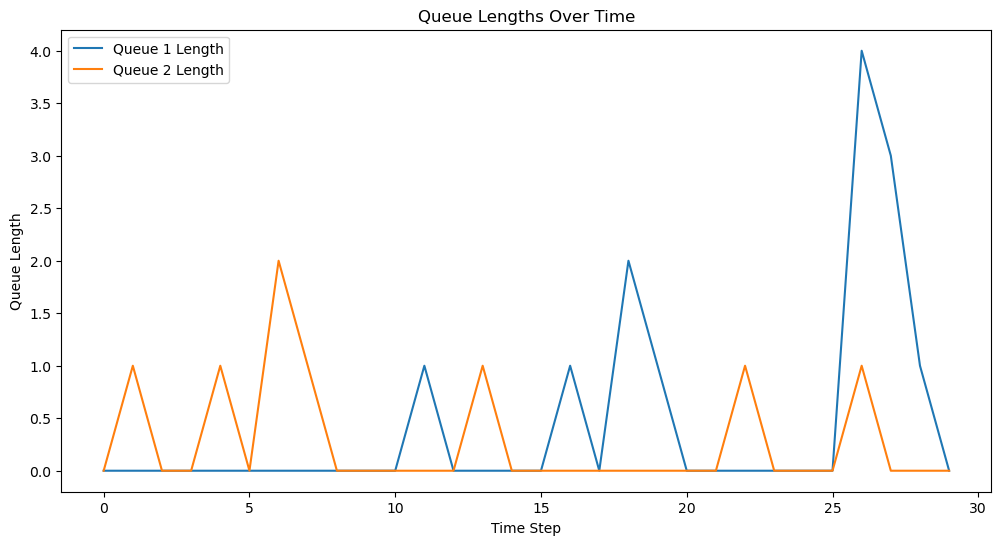

In [6]:
# Ploting queue lenghts for both queue in a single plot
queue_1_len = [q[0] for q in total_queue_len]
queue_2_len = [q[1] for q in total_queue_len]

plt.figure(figsize=(12, 6))
plt.plot(queue_1_len, label="Queue 1 Length")
plt.plot(queue_2_len, label="Queue 2 Length")
plt.xlabel("Time Step")
plt.ylabel("Queue Length")
plt.title("Queue Lengths Over Time")
plt.legend()
plt.show()


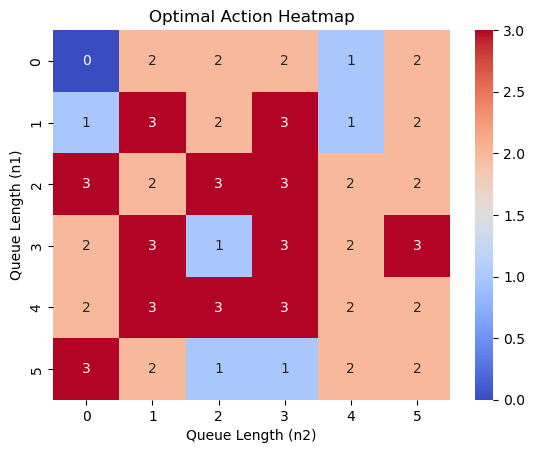

In [7]:
import numpy as np
import seaborn as sns

# Converting policy to numerical values for plotting
action_map = {'a1': 1, 'a2': 2, 'a1_a2': 3, "No Specific Action - Just update the queue": 0}
policy_numerical = [action_map[policy[state]] for state in states]

# Reshaping data for heatmap if necessary (depends on the state dimensions)
policy_array = np.array(policy_numerical).reshape((M+1, M+1, 2, 2))

# Heatmap
sns.heatmap(policy_array[:, :, 0, 0], annot=True, cmap="coolwarm", cbar=True, xticklabels=range(M+1), yticklabels=range(M+1))
plt.xlabel("Queue Length (n2)")
plt.ylabel("Queue Length (n1)")
plt.title("Optimal Action Heatmap")
plt.show()


In [8]:
server1_busy_states = [state[2] for state in states[:T]]
server2_busy_states = [state[3] for state in states[:T]]

print("Server 1 Busy States:", server1_busy_states)
print("Server 2 Busy States:", server2_busy_states)


Server 1 Busy States: [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]
Server 2 Busy States: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


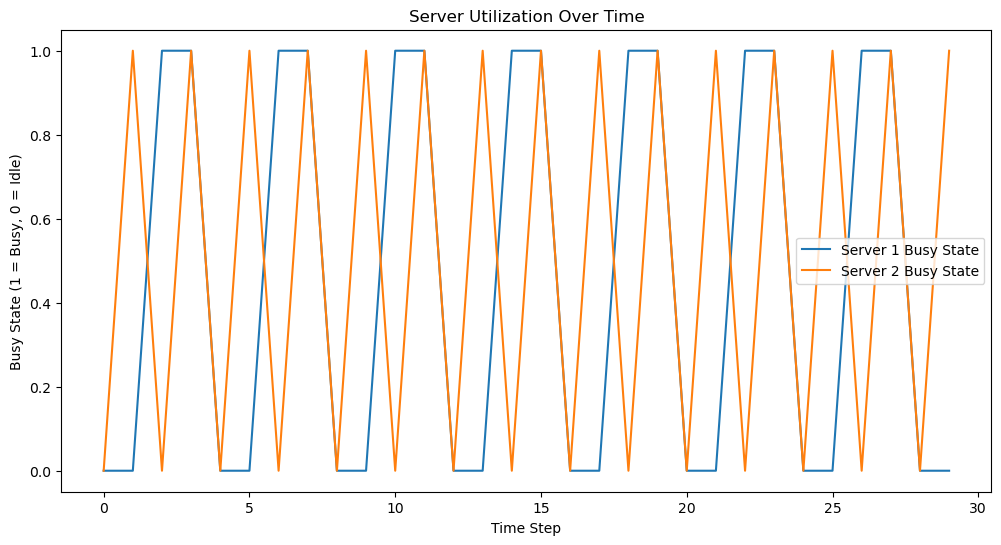

In [9]:
# Tracking server busy states during simulation 
plt.figure(figsize=(12, 6))
plt.plot(server1_busy_states, label="Server 1 Busy State")
plt.plot(server2_busy_states, label="Server 2 Busy State")
plt.xlabel("Time Step")
plt.ylabel("Busy State (1 = Busy, 0 = Idle)")
plt.title("Server Utilization Over Time")
plt.legend()
plt.show()
